# mnist

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale(60000,780).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/multiclass/mnist_scale_test(10000,780).txt')
data_name = 'mnist'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

y_tr = (y_tr %2 == 0).astype(float)
y_test = (y_test %2 == 0).astype(float)

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape
print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 10000
of features: 778
mnist


## K-Means cluster centers

In [3]:
ind_num = 300
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([150., 200., 0.01])

## svi-L-BFGS-B-c method

In [5]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [6]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': False}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

In [7]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=10)

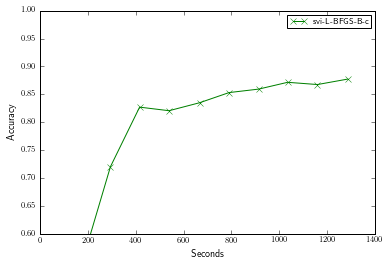

In [8]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method

In [9]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')

In [10]:
opts = {'maxiter':7, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Hyper-parameters at iteration 0 : [  1.50000000e+02   2.00000000e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.07866718e+02   2.32551937e+02   1.00000000e-02]
Hyper-parameters at iteration 2 : [  5.82162499e+01   2.48391754e+02   1.00000000e-02]
Hyper-parameters at iteration 3 : [  4.74352374e+01   2.50535430e+02   1.00000000e-02]
Hyper-parameters at iteration 4 : [  4.66898756e+01   2.50682887e+02   1.00000000e-02]
Hyper-parameters at iteration 5 : [  4.68736482e+01   2.50647561e+02   1.00000000e-02]
Hyper-parameters at iteration 6 : [  4.68728381e+01   2.50648010e+02   1.00000000e-02]
Hyper-parameters at iteration 7 : [  4.68774956e+01   2.50652773e+02   1.00000000e-02]
Hyper-parameters at iteration 8 : [  4.68774958e+01   2.50652773e+02   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  4.68774958e+01   2.50652773e+02   1.00000000e-02]
Hyper-parameters at iteration 0 : [  4.68774958e+01   2.50652773e+02   1.00000000e-02]
Hyper-parameters at iteration 1 : [

In [11]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)

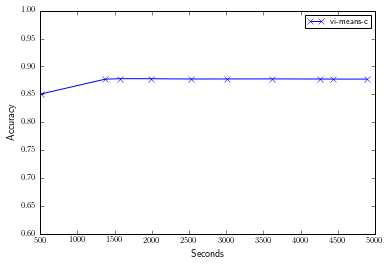

In [12]:
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [13]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 200, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

0
1
2
3
4


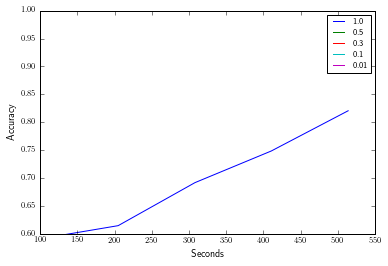

In [14]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=4)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [15]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 100, 'verbose': True, 'batch_size': 200, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  50 :
	Gradient norm 28.6741265206
Iteration  100 :
	Gradient norm 24.4295286134
Iteration  150 :
	Gradient norm 24.0649137393
Iteration  200 :
	Gradient norm 21.9844034951
Iteration  250 :
	Gradient norm 24.8721967074
Iteration  300 :
	Gradient norm 22.8905442608
Iteration  350 :
	Gradient norm 19.517572266
Iteration  400 :
	Gradient norm 19.8760108629
Iteration  450 :
	Gradient norm 19.1413176227
Iteration  500 :
	Gradient norm 15.7222540052
Iteration  550 :
	Gradient norm 18.8790580627
Iteration  600 :
	Gradient norm 18.63624773
Iteration  650 :
	Gradient norm 21.0681583518
Iteration  700 :
	Gradient norm 15.481545094
Iteration  750 :
	Gradient norm 15.2366613168
Iteration  800 :
	Gradient norm 15.5479765744
Iteration  850 :
	Gradient norm 25.4640035971
Iteration  900 :
	Gradient norm 16.4204179424
Iteration  950 :
	Gradient norm 13.8567369376
Iteration  1000 :
	Gradient norm 16.9240961059
Iteration  1050 :
	Gradient norm 11.9344580131
Iteration  1100 :
	Gradient norm 16.4

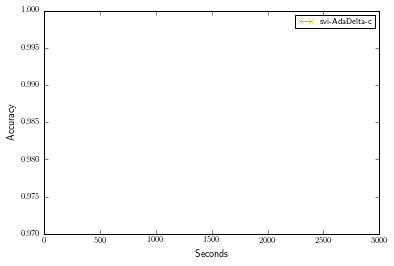

In [16]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=10)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0. 7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

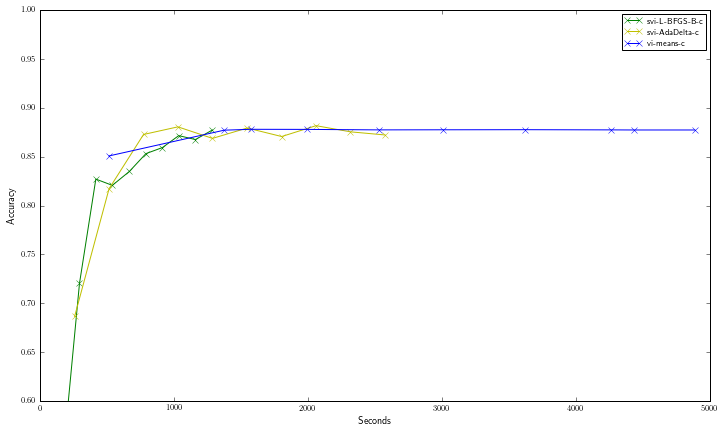

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.6, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [18]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)